## Motivation for the code and explanation [here](https://towardsdatascience.com/binary-classification-xgboost-hyperparameter-tuning-scenarios-by-non-exhaustive-grid-search-and-c261f4ce098d)

In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
#import comet_ml in the top of your file
from comet_ml import Experiment
import os
import matplotlib.pyplot as plt

from copy import deepcopy
import numpy as np
from sklearn.feature_selection import RFECV

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from skopt import BayesSearchCV
from sklearn import feature_selection
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
import xgboost as xgb
import pandas as pd
from ift6758.features.feature_engineering2 import SeasonDataSetTwo
from ift6758.metrics import plot_metrics
import random
random_state = 42
import tempfile


In [3]:
# Import comet_ml at the top of your file, before sklearn!
from comet_ml import Experiment
import os 
COMET=1
# Create an experiment with your api key
if COMET:
    comet_exp = Experiment(
        api_key=os.environ.get('COMET_API_KEY'),  # don’t hardcode!!
        project_name="milestone_2",
        workspace="morph-e",
        log_code=True,
    )

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/morph-e/milestone-2/ba43bca1cf664bf7830220a8b3f27c9b



In [4]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
seed = 42
seed_everything(seed)

In [5]:
### Script to get the DataFrame and Split the data into train and test set for FE1
years = [2015,2016,2017,2018]
dataset = SeasonDataSetTwo(years)
df_total = dataset.get_features_2()
df = df_total[df_total['gamePk'].astype(str).str[5]=='2']##Filtering only for regular dataframe

File already Exists, loading from ../ift6758/data/PICKLE//2015_2016_2017_2018_features2.pkl


In [6]:
pd.set_option('display.max_columns', None)

print(df.shape)
df.head()


(311106, 22)


,gamePk,team.name,gamePeriod,coordinatesX,coordinatesY,shotType,emptyNet,isHome,gameSeconds,totalGameSeconds,shotDistance,shotAngle,isGoal,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,timeFromLastEvent,distanceFromLastEvent,rebound,speed,changeInShotAngle,angleSpeed
0,2015020001,Toronto Maple Leafs,1,-55.0,6.0,Wrist Shot,0,True,51.0,51.0,34.525353,10.007980,0,Hit,94.0,-34.0,11.0,154.275727,False,14.025066,0.000000,0.000000
1,2015020001,Toronto Maple Leafs,1,-79.0,0.0,Snap Shot,0,True,65.0,65.0,10.000000,0.000000,0,Giveaway,-37.0,-28.0,7.0,50.477718,False,7.211103,0.000000,0.000000
2,2015020001,Toronto Maple Leafs,1,-75.0,-1.0,Snap Shot,0,True,66.0,66.0,14.035669,-4.085617,0,Shot,-79.0,0.0,1.0,4.123106,True,4.123106,4.085617,4.085617
3,2015020001,Toronto Maple Leafs,1,-55.0,-36.0,Wrist Shot,0,True,113.0,113.0,49.517674,-46.636577,0,Hit,-91.0,35.0,18.0,79.605276,False,4.422515,0.000000,0.000000
4,2015020001,Toronto Maple Leafs,1,-61.0,-1.0,Tip-In,0,True,157.0,157.0,28.017851,-2.045408,0,Faceoff,-69.0,-22.0,5.0,22.472205,False,4.494441,0.000000,0.000000


In [7]:
features = ['gameSeconds','totalGameSeconds','timeFromLastEvent','gamePeriod','shotType', 'shotAngle','isHome','coordinatesX','coordinatesY', 'shotDistance','lastEventType','lastEventCoordinatesX','lastEventCoordinatesY','distanceFromLastEvent', 'rebound','speed','changeInShotAngle']
label = ['isGoal']

In [8]:
df_exp = df[features+label]
print(df_exp.isna().any())
df_exp.head()


gameSeconds              False
totalGameSeconds         False
timeFromLastEvent        False
gamePeriod               False
shotType                  True
shotAngle                 True
isHome                    True
coordinatesX              True
coordinatesY              True
shotDistance              True
lastEventType            False
lastEventCoordinatesX     True
lastEventCoordinatesY     True
distanceFromLastEvent     True
rebound                  False
speed                     True
changeInShotAngle         True
isGoal                   False
dtype: bool


,gameSeconds,totalGameSeconds,timeFromLastEvent,gamePeriod,shotType,shotAngle,isHome,coordinatesX,coordinatesY,shotDistance,lastEventType,lastEventCoordinatesX,lastEventCoordinatesY,distanceFromLastEvent,rebound,speed,changeInShotAngle,isGoal
0,51.0,51.0,11.0,1,Wrist Shot,10.007980,True,-55.0,6.0,34.525353,Hit,94.0,-34.0,154.275727,False,14.025066,0.000000,0
1,65.0,65.0,7.0,1,Snap Shot,0.000000,True,-79.0,0.0,10.000000,Giveaway,-37.0,-28.0,50.477718,False,7.211103,0.000000,0
2,66.0,66.0,1.0,1,Snap Shot,-4.085617,True,-75.0,-1.0,14.035669,Shot,-79.0,0.0,4.123106,True,4.123106,4.085617,0
3,113.0,113.0,18.0,1,Wrist Shot,-46.636577,True,-55.0,-36.0,49.517674,Hit,-91.0,35.0,79.605276,False,4.422515,0.000000,0
4,157.0,157.0,5.0,1,Tip-In,-2.045408,True,-61.0,-1.0,28.017851,Faceoff,-69.0,-22.0,22.472205,False,4.494441,0.000000,0


### Instead of removing nan and inf -> Converting them to Nans. and XGBoost considers them as not existing features internally

In [9]:
## Removing nan and inf data of features 

remove_nan_inf_features= ["shotAngle","coordinatesX","coordinatesY","shotDistance","lastEventCoordinatesX","lastEventCoordinatesY","distanceFromLastEvent","speed","changeInShotAngle"]
df_exp.replace([np.inf, -np.inf], np.nan, inplace=True)
df_exp.replace([np.inf, -np.inf], np.nan, inplace=True)
df_exp["changeInShotAngle"].replace(0,np.nan,inplace=True)


## Converting category features to Category Types
categories = ['shotType','gamePeriod','lastEventType','rebound','isHome']
df_exp[categories]=df_exp[categories].astype("category")


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\pandas\core\frame.py:5238: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\pandas\core\generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\pandas\core\frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

In [10]:
def XY(df,label_column,features):
    X = df.drop([label_column],axis=1)[features]
    Y = df[label_column]
    # scaler = preprocessing.MinMaxScaler()
    # X=scaler.fit_transform(X)

    return X,Y

In [11]:
predscore_val_dict={}

weights_dir = "../ift6758/models/weights/"

## XGBoost with distance +angle

In [12]:
import joblib

In [14]:
experiment = "xg-dis-angle"
features = ["shotDistance","shotAngle"]
label_column = "isGoal"

## Splitting X and Y
val_ratio = 0.25
X,y = XY(df_exp,label_column,features)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, y,stratify=y,test_size=val_ratio,random_state=seed)

## Training
clf = xgb.XGBClassifier(booster='gbtree',use_label_encoder=False)
clf.fit(Xtrain, Ytrain)
y_pred_val  = clf.predict(Xval)
y_pred_val_scores = clf.predict_proba(Xval)[:,1]


predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['val']=Yval
predscore_val_dict[experiment]['predscore']=y_pred_val_scores



## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(clf,filename)

C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


['../ift6758/models/weights//xg-dis-angle.pkl']

              precision    recall  f1-score   support

           0       0.91      1.00      0.95     70480
           1       0.43      0.00      0.01      7297

    accuracy                           0.91     77777
   macro avg       0.67      0.50      0.48     77777
weighted avg       0.86      0.91      0.86     77777



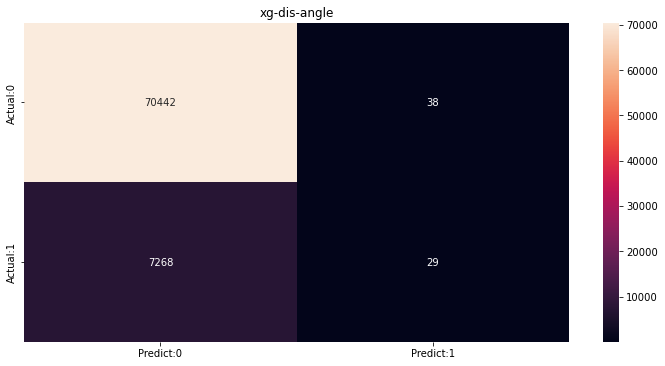

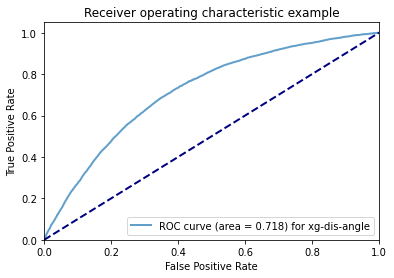

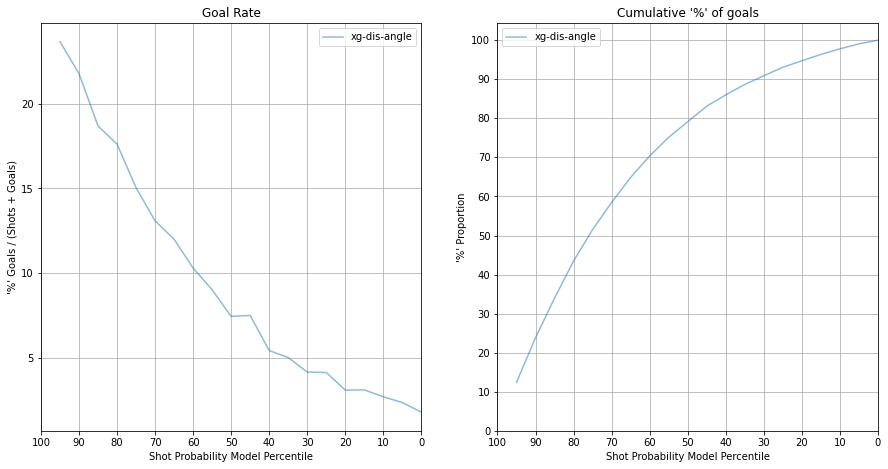

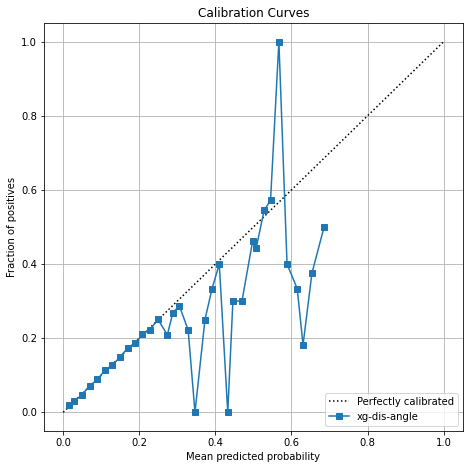

In [15]:
img_path = os.path.join(tempfile.mkdtemp(), 'imgs')

plot_metrics.plotConfusion(Yval,y_pred_val, title=experiment)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_roc([Yval],[y_pred_val_scores],[experiment])
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_percentile([Yval],[y_pred_val_scores],bin_width=5,plot_labels=[experiment])
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)
if COMET:
    comet_exp.log_figure(figure=plt)

In [16]:
if COMET:
    comet_exp.log_model("XG Boost", f"{weights_dir}/{experiment}.pkl")

In [17]:
experiment = "xg-dis"
features = ["shotDistance"]
label_column = "isGoal"

## Splitting X and Y
val_ratio = 0.25
X,y = XY(df_exp,label_column,features)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, y,stratify=y,test_size=val_ratio,random_state=seed)

## Training
clf = xgb.XGBClassifier(booster='gbtree',use_label_encoder=False)
clf.fit(Xtrain, Ytrain)
y_pred_val  = clf.predict(Xval)
y_pred_val_scores = clf.predict_proba(Xval)[:,1]


predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['val']=Yval
predscore_val_dict[experiment]['predscore']=y_pred_val_scores



## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(clf,filename)

C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


['../ift6758/models/weights//xg-dis.pkl']

In [20]:
experiment = "xg-dis"

if COMET:
    comet_exp.log_model("XG Boost", f"{weights_dir}/{experiment}.pkl")

In [18]:
experiment = "xg-angle"
features = ["shotAngle"]
label_column = "isGoal"

## Splitting X and Y
val_ratio = 0.25
X,y = XY(df_exp,label_column,features)
Xtrain, Xval, Ytrain, Yval = train_test_split(X, y,stratify=y,test_size=val_ratio,random_state=seed)

## Training
clf = xgb.XGBClassifier(booster='gbtree',use_label_encoder=False)
clf.fit(Xtrain, Ytrain)
y_pred_val  = clf.predict(Xval)
y_pred_val_scores = clf.predict_proba(Xval)[:,1]


predscore_val_dict[experiment]={}
predscore_val_dict[experiment]['val']=Yval
predscore_val_dict[experiment]['predscore']=y_pred_val_scores



## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(clf,filename)

C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


['../ift6758/models/weights//xg-angle.pkl']

In [19]:
if COMET:
    comet_exp.log_model("XG Boost", f"{weights_dir}/{experiment}.pkl")

In [21]:
experiments = predscore_val_dict.keys()
Ytrues=[predscore_val_dict[experiment]['val'] for experiment in experiments]
Yscores=[predscore_val_dict[experiment]['predscore'] for experiment in experiments]
plot_labels=experiments


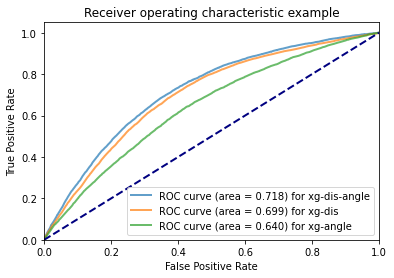

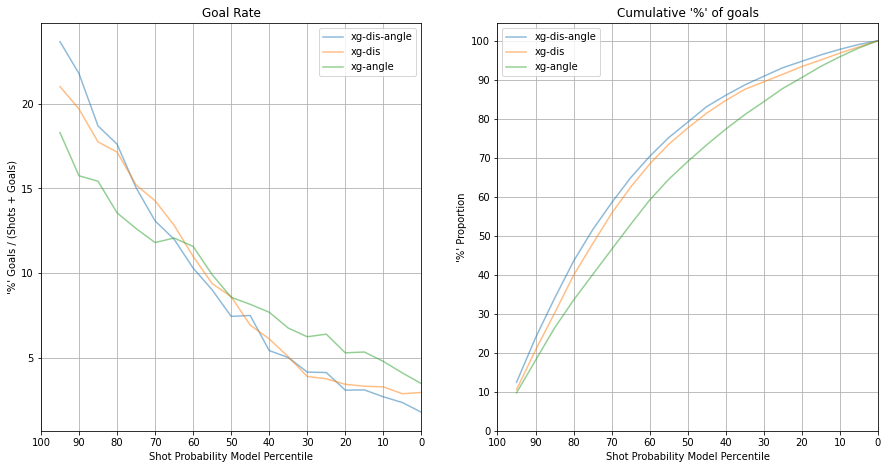

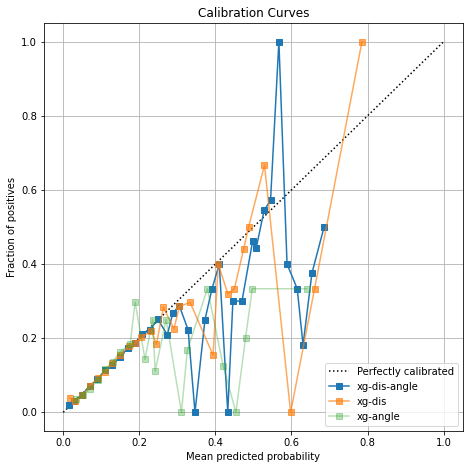

In [24]:
plot_metrics.plot_roc(Ytrues,Yscores,plot_labels)
plot_metrics.plot_percentile(Ytrues,Yscores,bin_width=5,plot_labels=plot_labels)
plot_metrics.plot_calibration(Ytrues,Yscores,plot_labels=plot_labels,n_bins=50)


In [25]:
comet_exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/morph-e/milestone-2/be7ebecea1bd4b31a14969570f9a80fd
COMET INFO:   Parameters:
COMET INFO:     begin_iteration : 0
COMET INFO:     booster         : gbtree
COMET INFO:     end_iteration   : 100
COMET INFO:     feature_names   : ['shotDistance', 'shotAngle']
COMET INFO:     feature_types   : ['float', 'float']
COMET INFO:     objective       : binary:logistic
COMET INFO:     rank            : 0
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (869.28 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     model-element            : 3 (1.12 MB)


## XG Boost with Feature Selection


In [13]:
val_ratio = 0.25
X= df_exp.drop(label,axis=1)
y= df_exp[label]


Xtrain, Xval, Ytrain, Yval = train_test_split(X, y,stratify=y,test_size=val_ratio,random_state=seed)


## Recursive feature Elimination

In [28]:
# Reference: https://www.kaggle.com/attackgnome/basic-feature-benchmark-rfecv-xgboost
# choose estimator/model type for Recursive feature elimination and cross valiation
experiment = "xgbase-allfeatures"

#obtaining default parameters by calling .fit() to XGBoost model instance
estimator = xgb.XGBClassifier(objective='binary:logistic',
                         enable_categorical=1,
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='gpu_hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                        )
selector = RFECV(estimator, step=1, min_features_to_select=1, cv=5, scoring='roc_auc',verbose=1,n_jobs=4)

#fit the model, get a rank of the variables, and a matrix of the selected X variables
Xtrainfloats = Xtrain.drop(categories,axis=1)
selector = selector.fit(Xtrainfloats, Ytrain.values.flatten())



Fitting estimator with 12 features.


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Fitting estimator with 11 features.


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


Fitting estimator with 10 features.


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\base.py:445: UserWarning: X does not have valid feature names, but RFECV was fitted with feature names
  warnings.warn(
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is 

C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\sklearn\utils\deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


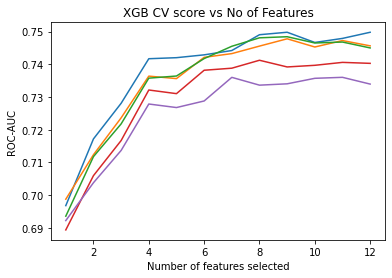

In [32]:

#PLot # of features selected vs. Model Score
import matplotlib.pyplot as plt
plt.figure()
plt.title('XGB CV score vs No of Features')
plt.xlabel("Number of features selected")
plt.ylabel("ROC-AUC")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)
if COMET:
    comet_exp.log_figure(figure=plt)
plt.show()

#get rank of X model features
rank = selector.ranking_


In [30]:
Xtrainfloats.columns[selector.support_]

Index(['totalGameSeconds', 'timeFromLastEvent', 'shotAngle', 'coordinatesY',
       'shotDistance', 'lastEventCoordinatesY', 'distanceFromLastEvent',
       'speed', 'changeInShotAngle'],
      dtype='object')

In [31]:
dropColumns = Xtrainfloats.columns[np.logical_not(selector.support_)]
print(dropColumns)

Index(['gameSeconds', 'coordinatesX', 'lastEventCoordinatesX'], dtype='object')


In [33]:
#obtaining default parameters by calling .fit() to XGBoost model instance
estimator = xgb.XGBClassifier(objective='binary:logistic',
                         enable_categorical=1,
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='gpu_hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                        )
estimator.fit(Xtrain, Ytrain.values.flatten())


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=1,
              eval_metric='auc', gamma=0, gpu_id=0, grow_policy='lossguide',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=12, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='gpu_hist',
              use_label_encoder=False, validate_parameters=1, ...)

In [38]:
feature_scores = pd.Series(estimator.feature_importances_, index=Xtrain.columns).sort_values(ascending=False)


In [39]:
# feature_scores

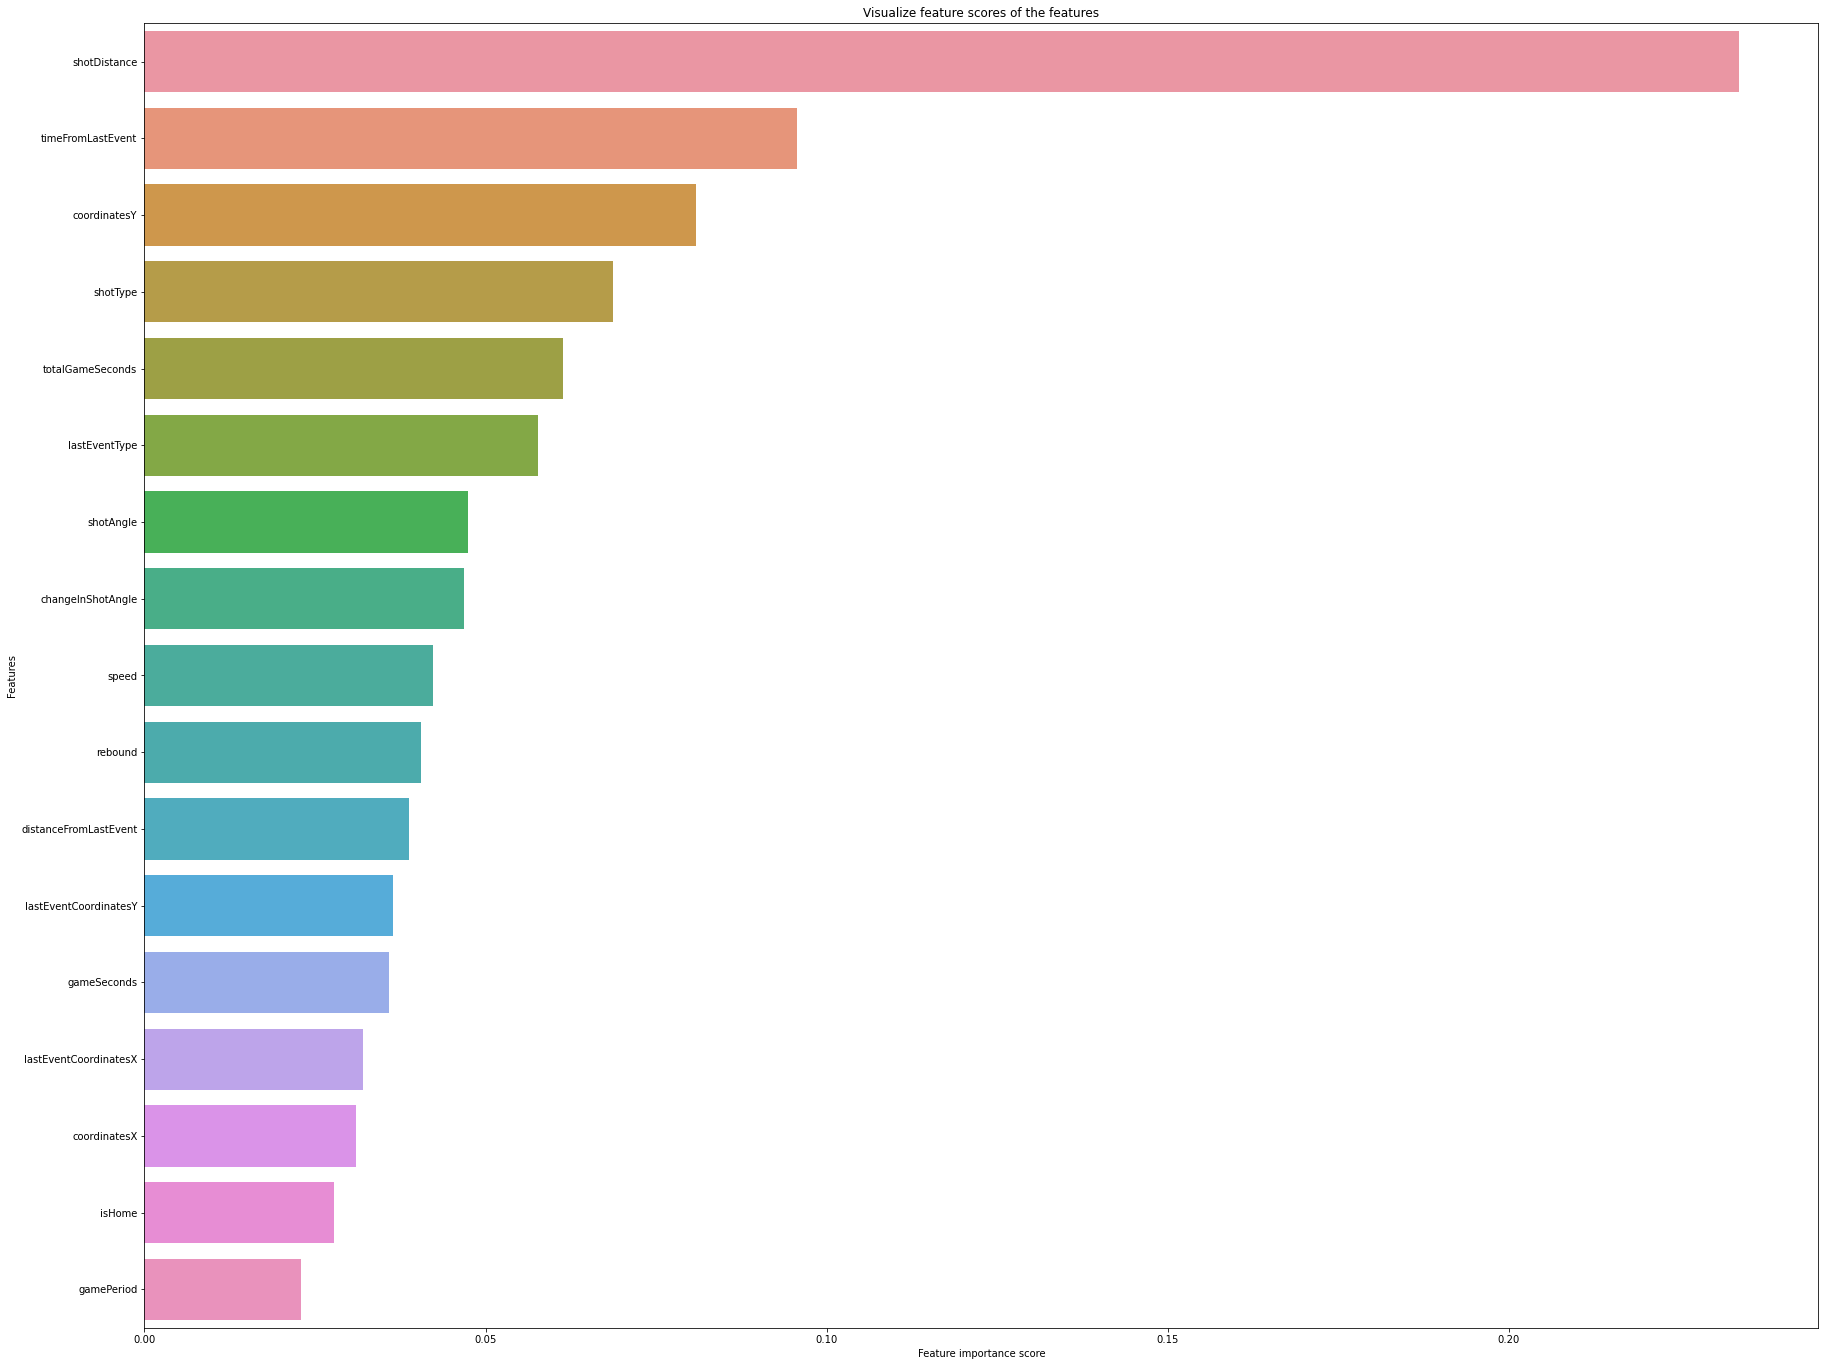

In [40]:
# Creating a seaborn bar plot
import seaborn as sns
f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index)
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
if COMET:
    comet_exp.log_figure(figure=plt)
plt.show()

In [14]:
# To Be Done for Best Shot
### Apply XGB on features from FE2
#dictionary for collecting results
results_dict = {}
experiment = "xgbase-allfeatures"

#obtaining default parameters by calling .fit() to XGBoost model instance
xgb2 = xgb.XGBClassifier(objective='binary:logistic',
                         enable_categorical=1,
                          booster='gbtree',
                          eval_metric='auc',
                          tree_method='gpu_hist',
                          grow_policy='lossguide',
                          use_label_encoder=False,
                        )
xgb2.fit(Xtrain, Ytrain)

#extracting default parameters from benchmark model
default_params = {}
gparams = xgb2.get_params()

#default parameters have to be wrapped in lists - even single values - so GridSearchCV can take them as inputs
for key in gparams.keys():
    gp = gparams[key]
    default_params[key] = [gp]

#benchmark model. Grid search is not performed, since only single values are provided as parameter grid.
#However, cross-validation is still executed
clf0 = GridSearchCV(estimator=xgb2, scoring='roc_auc', param_grid=default_params, return_train_score=True, verbose=1, cv=3)
clf0.fit(Xtrain, Ytrain.values.ravel())

#results dataframe
df = pd.DataFrame(clf0.cv_results_)

#best parameters
bp = clf0.best_params_

#storing computed values in results dictionary
results_dict[experiment] = {'iterable_parameter': np.nan,
                         'classifier': deepcopy(clf0),
                         'cv_results': df.copy(),
                         'best_params': bp}


y_pred_val  = clf0.predict(Xval)
y_pred_val_scores = clf0.predict_proba(Xval)[:,1]


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET WARNING: You must install graphviz to plot tree


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgb

In [15]:
experiment

'xgbase-allfeatures'

In [16]:
## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(clf0,filename)


['../ift6758/models/weights//xgbase-allfeatures.pkl']

In [55]:
# if COMET:
#     comet_exp.log_model(experiment, f"{weights_dir}/{experiment}-yearvalidation.pkl")

In [17]:

# plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
# if COMET:
#     comet_exp.log_figure(figure=plt)
# plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)
# if COMET:
#     comet_exp.log_figure(figure=plt)




In [18]:

from sklearn.model_selection import StratifiedKFold


In [19]:
##Hyperparameter Tuning
#creating deepcopy of default parameters before manipulations
experiment = "xgbase-bayestuning-allfeatures"
params = deepcopy(default_params)

#setting grid of selected parameters for iteration
param_grid = {'gamma': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4, 200],
              'learning_rate': [0.01, 0.03, 0.06, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6, 0.7],
              'max_depth': [5,6,7,8,9,10,11,12,13,14],
              'n_estimators': [50,65,80,100,115,130,150],
            #   'reg_alpha': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200],
            #   'reg_lambda': [0,0.1,0.2,0.4,0.8,1.6,3.2,6.4,12.8,25.6,51.2,102.4,200]
              }

#No. of jobs
bcvj = int(np.cumsum([len(x) for x in param_grid.values()])[-1])

#unwrapping list values of default parameters
default_params_xgb = {}

for key in default_params.keys():
    default_params_xgb[key] = default_params[key][0]

#providing default parameters to xgbc model, before randomized search cross-validation
xgb3 = xgb.XGBClassifier(**default_params_xgb)

clf = BayesSearchCV(estimator=xgb3, search_spaces=param_grid, n_iter=bcvj, scoring='roc_auc', return_train_score=True, verbose=3,
                    cv = StratifiedKFold(
                            n_splits=3,
                            shuffle=True
                        ))
clf.fit(Xtrain, Ytrain.values.ravel())

#results dataframe
df = pd.DataFrame(clf.cv_results_)

#best parameters
bp = clf.best_params_

#storing computed values in results dictionary
results_dict[experiment] = {'iterable_parameter': np.nan,
                        'classifier': deepcopy(clf),
                        'cv_results': df.copy(),
                        'best_params': bp}


y_pred_val  = clf.predict(Xval)
y_pred_val_scores = clf.predict_proba(Xval)[:,1]

Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=1.6, learning_rate=0.4, max_depth=13, n_estimators=80;, score=(train=0.942, test=0.735) total time=   2.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=1.6, learning_rate=0.4, max_depth=13, n_estimators=80;, score=(train=0.944, test=0.734) total time=   2.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=1.6, learning_rate=0.4, max_depth=13, n_estimators=80;, score=(train=0.929, test=0.735) total time=   2.2s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.0, learning_rate=0.06, max_depth=6, n_estimators=115;, score=(train=0.791, test=0.761) total time=   1.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.0, learning_rate=0.06, max_depth=6, n_estimators=115;, score=(train=0.790, test=0.760) total time=   1.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=0.0, learning_rate=0.06, max_depth=6, n_estimators=115;, score=(train=0.789, test=0.765) total time=   1.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=51.2, learning_rate=0.6, max_depth=5, n_estimators=80;, score=(train=0.750, test=0.751) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=51.2, learning_rate=0.6, max_depth=5, n_estimators=80;, score=(train=0.751, test=0.747) total time=   0.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=51.2, learning_rate=0.6, max_depth=5, n_estimators=80;, score=(train=0.751, test=0.741) total time=   0.4s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.4, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.780, test=0.758) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.4, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.778, test=0.764) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=0.4, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.780, test=0.762) total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=51.2, learning_rate=0.03, max_depth=11, n_estimators=115;, score=(train=0.747, test=0.746) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=51.2, learning_rate=0.03, max_depth=11, n_estimators=115;, score=(train=0.747, test=0.743) total time=   1.1s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=51.2, learning_rate=0.03, max_depth=11, n_estimators=115;, score=(train=0.749, test=0.742) total time=   0.8s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=25.6, learning_rate=0.3, max_depth=10, n_estimators=150;, score=(train=0.761, test=0.754) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=25.6, learning_rate=0.3, max_depth=10, n_estimators=150;, score=(train=0.761, test=0.749) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=25.6, learning_rate=0.3, max_depth=10, n_estimators=150;, score=(train=0.758, test=0.760) total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.4, learning_rate=0.3, max_depth=6, n_estimators=100;, score=(train=0.849, test=0.754) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.4, learning_rate=0.3, max_depth=6, n_estimators=100;, score=(train=0.852, test=0.750) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=0.4, learning_rate=0.3, max_depth=6, n_estimators=100;, score=(train=0.848, test=0.754) total time=   1.1s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.1, learning_rate=0.03, max_depth=14, n_estimators=130;, score=(train=0.954, test=0.753) total time=  32.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.1, learning_rate=0.03, max_depth=14, n_estimators=130;, score=(train=0.953, test=0.751) total time=  31.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 3/3] END gamma=0.1, learning_rate=0.03, max_depth=14, n_estimators=130;, score=(train=0.953, test=0.750) total time=  30.5s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=12.8, learning_rate=0.1, max_depth=10, n_estimators=65;, score=(train=0.770, test=0.760) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=12.8, learning_rate=0.1, max_depth=10, n_estimators=65;, score=(train=0.770, test=0.758) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=12.8, learning_rate=0.1, max_depth=10, n_estimators=65;, score=(train=0.769, test=0.761) total time=   0.7s
Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.1, learning_rate=0.7, max_depth=5, n_estimators=65;, score=(train=0.825, test=0.744) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.1, learning_rate=0.7, max_depth=5, n_estimators=65;, score=(train=0.826, test=0.740) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.1, learning_rate=0.7, max_depth=5, n_estimators=65;, score=(train=0.827, test=0.745) total time=   0.6s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=6.4, learning_rate=0.2, max_depth=7, n_estimators=115;, score=(train=0.783, test=0.765) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=6.4, learning_rate=0.2, max_depth=7, n_estimators=115;, score=(train=0.787, test=0.758) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=6.4, learning_rate=0.2, max_depth=7, n_estimators=115;, score=(train=0.785, test=0.761) total time=   0.7s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.1, learning_rate=0.15, max_depth=8, n_estimators=65;, score=(train=0.846, test=0.758) total time=   2.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.1, learning_rate=0.15, max_depth=8, n_estimators=65;, score=(train=0.852, test=0.758) total time=   1.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.1, learning_rate=0.15, max_depth=8, n_estimators=65;, score=(train=0.847, test=0.763) total time=   1.9s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.8, learning_rate=0.5, max_depth=8, n_estimators=65;, score=(train=0.884, test=0.736) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.8, learning_rate=0.5, max_depth=8, n_estimators=65;, score=(train=0.896, test=0.735) total time=   1.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.8, learning_rate=0.5, max_depth=8, n_estimators=65;, score=(train=0.877, test=0.739) total time=   1.2s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=25.6, learning_rate=0.01, max_depth=14, n_estimators=65;, score=(train=0.740, test=0.736) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=25.6, learning_rate=0.01, max_depth=14, n_estimators=65;, score=(train=0.739, test=0.738) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=25.6, learning_rate=0.01, max_depth=14, n_estimators=65;, score=(train=0.738, test=0.732) total time=   0.8s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.8, learning_rate=0.25, max_depth=8, n_estimators=65;, score=(train=0.866, test=0.754) total time=   1.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.8, learning_rate=0.25, max_depth=8, n_estimators=65;, score=(train=0.864, test=0.753) total time=   1.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.8, learning_rate=0.25, max_depth=8, n_estimators=65;, score=(train=0.867, test=0.752) total time=   1.4s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.1, learning_rate=0.06, max_depth=5, n_estimators=50;, score=(train=0.761, test=0.748) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.1, learning_rate=0.06, max_depth=5, n_estimators=50;, score=(train=0.759, test=0.755) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.1, learning_rate=0.06, max_depth=5, n_estimators=50;, score=(train=0.760, test=0.752) total time=   0.5s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=65;, score=(train=0.925, test=0.746) total time=   3.0s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=65;, score=(train=0.920, test=0.750) total time=   3.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=1.6, learning_rate=0.2, max_depth=12, n_estimators=65;, score=(train=0.923, test=0.750) total time=   2.9s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=51.2, learning_rate=0.15, max_depth=9, n_estimators=150;, score=(train=0.749, test=0.750) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=51.2, learning_rate=0.15, max_depth=9, n_estimators=150;, score=(train=0.750, test=0.745) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=51.2, learning_rate=0.15, max_depth=9, n_estimators=150;, score=(train=0.752, test=0.745) total time=   0.6s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=6.4, learning_rate=0.1, max_depth=9, n_estimators=100;, score=(train=0.792, test=0.764) total time=   1.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=6.4, learning_rate=0.1, max_depth=9, n_estimators=100;, score=(train=0.793, test=0.763) total time=   1.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=6.4, learning_rate=0.1, max_depth=9, n_estimators=100;, score=(train=0.793, test=0.759) total time=   1.1s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.8, learning_rate=0.1, max_depth=13, n_estimators=130;, score=(train=0.964, test=0.748) total time=  10.1s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.8, learning_rate=0.1, max_depth=13, n_estimators=130;, score=(train=0.965, test=0.750) total time=  10.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.8, learning_rate=0.1, max_depth=13, n_estimators=130;, score=(train=0.962, test=0.752) total time=   9.8s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=1.6, learning_rate=0.25, max_depth=9, n_estimators=130;, score=(train=0.858, test=0.757) total time=   1.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=1.6, learning_rate=0.25, max_depth=9, n_estimators=130;, score=(train=0.856, test=0.756) total time=   1.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=1.6, learning_rate=0.25, max_depth=9, n_estimators=130;, score=(train=0.857, test=0.755) total time=   1.4s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=200.0, learning_rate=0.06, max_depth=8, n_estimators=100;, score=(train=0.729, test=0.731) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=200.0, learning_rate=0.06, max_depth=8, n_estimators=100;, score=(train=0.733, test=0.728) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=200.0, learning_rate=0.06, max_depth=8, n_estimators=100;, score=(train=0.732, test=0.729) total time=   0.5s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=1.6, learning_rate=0.1, max_depth=9, n_estimators=80;, score=(train=0.855, test=0.761) total time=   2.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=1.6, learning_rate=0.1, max_depth=9, n_estimators=80;, score=(train=0.855, test=0.761) total time=   2.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=1.6, learning_rate=0.1, max_depth=9, n_estimators=80;, score=(train=0.860, test=0.758) total time=   2.6s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=6.4, learning_rate=0.1, max_depth=12, n_estimators=100;, score=(train=0.800, test=0.761) total time=   1.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=6.4, learning_rate=0.1, max_depth=12, n_estimators=100;, score=(train=0.800, test=0.763) total time=   1.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=6.4, learning_rate=0.1, max_depth=12, n_estimators=100;, score=(train=0.800, test=0.763) total time=   1.3s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=25.6, learning_rate=0.1, max_depth=12, n_estimators=80;, score=(train=0.761, test=0.755) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=25.6, learning_rate=0.1, max_depth=12, n_estimators=80;, score=(train=0.760, test=0.755) total time=   0.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=25.6, learning_rate=0.1, max_depth=12, n_estimators=80;, score=(train=0.761, test=0.754) total time=   0.7s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.4, learning_rate=0.1, max_depth=12, n_estimators=115;, score=(train=0.962, test=0.746) total time=  10.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.4, learning_rate=0.1, max_depth=12, n_estimators=115;, score=(train=0.965, test=0.746) total time=  10.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.4, learning_rate=0.1, max_depth=12, n_estimators=115;, score=(train=0.967, test=0.752) total time=  10.7s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=51.2, learning_rate=0.25, max_depth=6, n_estimators=50;, score=(train=0.752, test=0.744) total time=   0.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=51.2, learning_rate=0.25, max_depth=6, n_estimators=50;, score=(train=0.750, test=0.752) total time=   0.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=51.2, learning_rate=0.25, max_depth=6, n_estimators=50;, score=(train=0.751, test=0.748) total time=   0.3s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.4, learning_rate=0.1, max_depth=12, n_estimators=100;, score=(train=0.960, test=0.748) total time=   9.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.4, learning_rate=0.1, max_depth=12, n_estimators=100;, score=(train=0.961, test=0.753) total time=  10.0s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.4, learning_rate=0.1, max_depth=12, n_estimators=100;, score=(train=0.954, test=0.752) total time=   9.8s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=6.4, learning_rate=0.2, max_depth=9, n_estimators=130;, score=(train=0.791, test=0.760) total time=   1.0s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=6.4, learning_rate=0.2, max_depth=9, n_estimators=130;, score=(train=0.792, test=0.763) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=6.4, learning_rate=0.2, max_depth=9, n_estimators=130;, score=(train=0.795, test=0.758) total time=   0.9s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=51.2, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.751, test=0.747) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=51.2, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.751, test=0.745) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=51.2, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.750, test=0.749) total time=   0.5s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=6.4, learning_rate=0.1, max_depth=11, n_estimators=65;, score=(train=0.798, test=0.763) total time=   1.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=6.4, learning_rate=0.1, max_depth=11, n_estimators=65;, score=(train=0.798, test=0.761) total time=   1.2s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=6.4, learning_rate=0.1, max_depth=11, n_estimators=65;, score=(train=0.798, test=0.763) total time=   1.2s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.2, learning_rate=0.3, max_depth=10, n_estimators=130;, score=(train=0.991, test=0.729) total time=   5.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.2, learning_rate=0.3, max_depth=10, n_estimators=130;, score=(train=0.990, test=0.721) total time=   5.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.2, learning_rate=0.3, max_depth=10, n_estimators=130;, score=(train=0.994, test=0.722) total time=   6.6s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.0, learning_rate=0.06, max_depth=5, n_estimators=130;, score=(train=0.777, test=0.763) total time=   2.1s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.0, learning_rate=0.06, max_depth=5, n_estimators=130;, score=(train=0.781, test=0.756) total time=   1.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.0, learning_rate=0.06, max_depth=5, n_estimators=130;, score=(train=0.778, test=0.765) total time=   1.3s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.2, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.781, test=0.757) total time=   1.1s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.2, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.777, test=0.765) total time=   0.9s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.2, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.779, test=0.764) total time=   0.8s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.4, learning_rate=0.5, max_depth=10, n_estimators=115;, score=(train=0.981, test=0.715) total time=   3.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.4, learning_rate=0.5, max_depth=10, n_estimators=115;, score=(train=0.991, test=0.713) total time=   4.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.4, learning_rate=0.5, max_depth=10, n_estimators=115;, score=(train=0.983, test=0.712) total time=   3.8s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=3.2, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.780, test=0.759) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=3.2, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.780, test=0.760) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=3.2, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.778, test=0.766) total time=   0.8s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=102.4, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.738, test=0.742) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=102.4, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.741, test=0.736) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=102.4, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.742, test=0.736) total time=   0.4s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.8, learning_rate=0.15, max_depth=6, n_estimators=100;, score=(train=0.815, test=0.758) total time=   1.6s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.8, learning_rate=0.15, max_depth=6, n_estimators=100;, score=(train=0.813, test=0.764) total time=   1.4s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.8, learning_rate=0.15, max_depth=6, n_estimators=100;, score=(train=0.816, test=0.763) total time=   1.2s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=102.4, learning_rate=0.7, max_depth=12, n_estimators=65;, score=(train=0.743, test=0.743) total time=   0.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=102.4, learning_rate=0.7, max_depth=12, n_estimators=65;, score=(train=0.736, test=0.739) total time=   0.3s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=102.4, learning_rate=0.7, max_depth=12, n_estimators=65;, score=(train=0.743, test=0.728) total time=   0.3s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.0, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.780, test=0.758) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.0, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.779, test=0.763) total time=   0.7s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.0, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.779, test=0.762) total time=   0.7s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.781, test=0.757) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.779, test=0.763) total time=   0.8s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=0.1, learning_rate=0.1, max_depth=5, n_estimators=80;, score=(train=0.779, test=0.764) total time=   0.9s


COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator
COMET ERROR: Failed to extract parameters from estimator


Fitting 3 folds for each of 1 candidates, totalling 3 fits


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 1/3] END gamma=200.0, learning_rate=0.1, max_depth=10, n_estimators=80;, score=(train=0.734, test=0.723) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


[CV 2/3] END gamma=200.0, learning_rate=0.1, max_depth=10, n_estimators=80;, score=(train=0.729, test=0.733) total time=   0.5s


C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)
COMET ERROR: Failed to extract parameters from estimator


[CV 3/3] END gamma=200.0, learning_rate=0.1, max_depth=10, n_estimators=80;, score=(train=0.730, test=0.731) total time=   0.4s


COMET ERROR: Failed to extract parameters from estimator
C:\Users\saiak\.conda\envs\ift6758-conda-env\lib\site-packages\xgboost\training.py:17: UserWarning: Old style callback is deprecated.  See: https://xgboost.readthedocs.io/en/latest/python/callbacks.html
  warnings.warn(f'Old style callback is deprecated.  See: {link}', UserWarning)


In [20]:
bp

OrderedDict([('gamma', 6.4),
             ('learning_rate', 0.1),
             ('max_depth', 12),
             ('n_estimators', 100)])

In [21]:
df_plotly = pd.DataFrame(clf.cv_results_["params"])
ploty_hover=df_plotly.columns
df_plotly["ROC_AUC_mean_fold_test_score"]=clf.cv_results_["mean_test_score"]
df_plotly=df_plotly.reset_index().rename(columns={'index':'experiment_number'})
df_plotly["Value"]="SubOptimal"
# Ref: https://stackoverflow.com/a/34162576
df_plotly.loc[(df_plotly[list(bp)]==pd.Series(bp)).all(axis=1),"Value"]="Best"


In [22]:
df_plotly.head()

,experiment_number,gamma,learning_rate,max_depth,n_estimators,ROC_AUC_mean_fold_test_score,Value
0,0,1.6,0.40,13,80,0.734744,SubOptimal
1,1,0.0,0.06,6,115,0.762013,SubOptimal
2,2,51.2,0.60,5,80,0.746569,SubOptimal
3,3,0.4,0.10,5,80,0.761139,SubOptimal
4,4,51.2,0.03,11,115,0.743835,SubOptimal


In [23]:
bp

OrderedDict([('gamma', 6.4),
             ('learning_rate', 0.1),
             ('max_depth', 12),
             ('n_estimators', 100)])

In [25]:
import plotly.express as px

fig = px.scatter(df_plotly, y="ROC_AUC_mean_fold_test_score",color="Value", x="experiment_number",hover_data=ploty_hover,title="Scatter BayesCV Experiments Scores")
# px.scatter()
fig.update_traces(marker_size=10)
fig.show()
fig.write_html(f"../ift6758/models/{experiment}.html",include_plotlyjs = 'cdn',include_mathjax ='cdn',)


In [84]:
df_plotly.head()

,gamma,learning_rate,max_depth,n_estimators,reg_alpha,reg_lambda,mean_test_score
0,1.6,0.40,13,80,12.8,1.6,0.756729
1,0.0,0.06,6,115,51.2,25.6,0.755294
2,51.2,0.60,5,80,102.4,0.8,0.735224
3,0.4,0.10,5,80,1.6,200.0,0.756031
4,51.2,0.03,11,115,6.4,1.6,0.741994


              precision    recall  f1-score   support

           0       0.91      1.00      0.95     70480
           1       0.60      0.03      0.06      7297

    accuracy                           0.91     77777
   macro avg       0.76      0.51      0.50     77777
weighted avg       0.88      0.91      0.87     77777



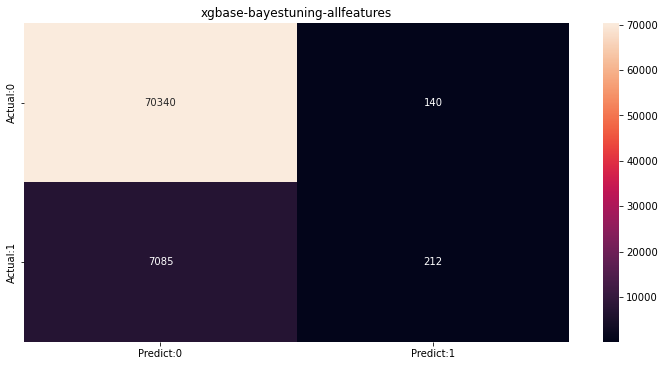

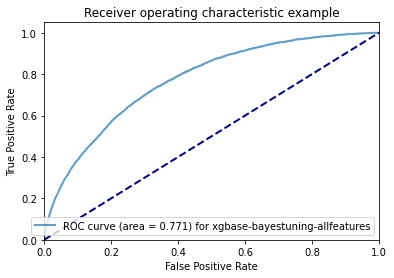

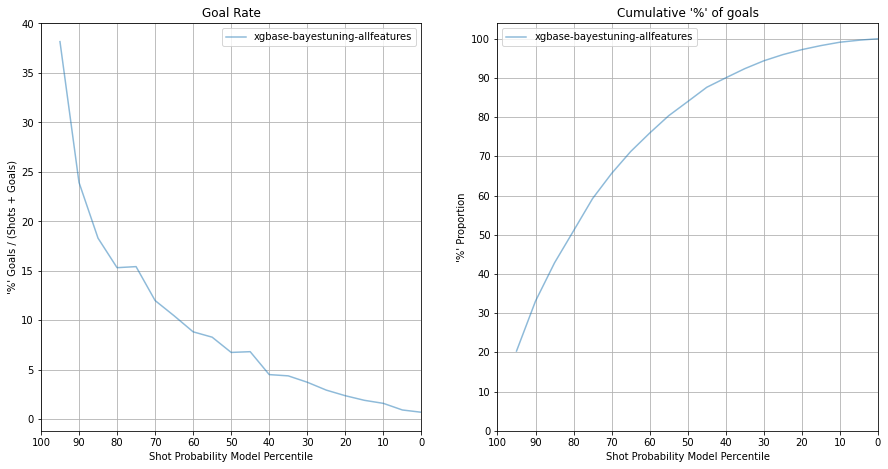

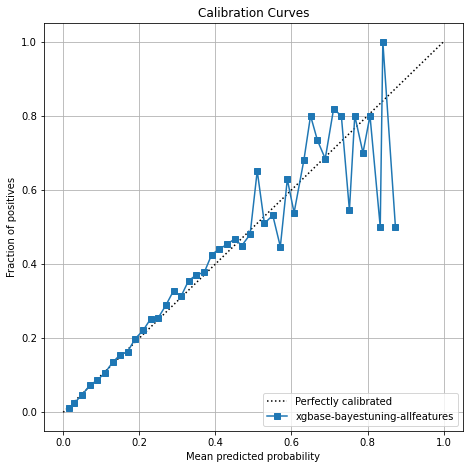

In [26]:

plot_metrics.plotConfusion(Yval,y_pred_val,title=experiment)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_roc([Yval],[y_pred_val_scores],plot_labels=[experiment])
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_percentile([Yval],[y_pred_val_scores],plot_labels=[experiment],bin_width=5)
if COMET:
    comet_exp.log_figure(figure=plt)
plot_metrics.plot_calibration([Yval],[y_pred_val_scores],plot_labels=[experiment],n_bins=50)
if COMET:
    comet_exp.log_figure(figure=plt)




In [27]:
## Dumping model
filename=f"{weights_dir}/{experiment}.pkl"
joblib.dump(clf0,filename)
if COMET:
    comet_exp.log_model(experiment, f"{filename}")

In [28]:
comet_exp.end()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/morph-e/milestone-2/ba43bca1cf664bf7830220a8b3f27c9b
COMET INFO:   Parameters:
COMET INFO:     alpha                                 : 1e-10
COMET INFO:     begin_iteration                       : 0
COMET INFO:     booster                               : gbtree
COMET INFO:     copy_X_train                          : True
COMET INFO:     cv                                    : 3
COMET INFO:     end_iteration                         : 100
COMET INFO:     error_score                           : nan
COMET INFO:     estimator                             : XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=1,
              eval_metric='auc', gamma=0, gpu_id=0, gro